# Анализ данных стриминг-сервиса

В данном проекте был произведен анализ данных стримингового сервича (онлайн-кинотеатра), данных о фильмах, их рейтинге, данных о пользователях и их предпочтениях. Были использованы библиотеки python: Pandas, Numpy для аналитических запросов, Seaborn для визуализации.

Для начала импортируем библиотеки python для анализа данных:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Обработка данных

#### 1.1 Импортирование файлов

Импортируем три дата сета с информацией о фильмах, их рейтинге, и пользователях стриминг-сервиса и преобразуем их в DataFrame

In [16]:
movies_data = pd.read_csv('/Users/grigorovakarina/Downloads/archive/Netflix_Dataset_Movie.csv')
ratings = pd.read_csv('/Users/grigorovakarina/Downloads/archive/Netflix_Dataset_Rating.csv')
users = pd.read_csv('/Users/grigorovakarina/Downloads/netflix_users.csv')

#### 1.2 Проверка DataFrame на наличие пустых значений:

In [20]:
print(movies_data.isnull().sum())
print(ratings.isnull().sum())
print(users.isnull().sum())

Movie_ID    0
Year        0
Name        0
dtype: int64
User_ID     0
Rating      0
Movie_ID    0
dtype: int64
User_ID              0
Name                 0
Age                  0
Country              0
Subscription_Type    0
Watch_Time_Hours     0
Favorite_Genre       0
Last_Login           0
dtype: int64


Был использован метод .isnull(), который возвращает DataFrame той же формы, но с булевыми значениями True или False. Затем был применен метод .sum(), чтобы найти количество ненулевых значений. Поскольку False возвращает ноль, видно, что во всех трех DataFrame нулевые значения отсутствуют.

#### 1.3 Заполнение пустых значений

Если бы в данных DataFrame присутствовали пустые значения, то преобразовать их можно было бы следующими способами:

In [25]:
ratings['Rating'] = ratings['Rating'].fillna(ratings['Rating'].mean())
users['Age'] = users['Age'].fillna(users['Age'].median())

Был применен метод .fillna(), который заполяет пустые значения в колонке 'Rating' значением в скобках. В данном случае пустые значения были заполнены средним значением в колонке 'Rating' с помощью метода .mean()

Для колонки 'Age' пустые значения были заполнены медианным значением при помощи метода .median()

#### 1.4 Объединение таблиц

In [31]:
merged_df = pd.merge(movies_data, ratings, on = 'Movie_ID')
rating_user = pd.merge(users, merged_df, on = 'User_ID')
print(rating_user.head())

   User_ID         Name_x  Age Country Subscription_Type  Watch_Time_Hours  \
0        6  David Johnson   21     USA          Standard            615.93   
1        6  David Johnson   21     USA          Standard            615.93   
2        6  David Johnson   21     USA          Standard            615.93   
3        6  David Johnson   21     USA          Standard            615.93   
4        6  David Johnson   21     USA          Standard            615.93   

  Favorite_Genre  Last_Login  Movie_ID  Year                  Name_y  Rating  
0        Romance  2025-02-03        30  2003  Something's Gotta Give       3  
1        Romance  2025-02-03       173  1968     The Devil's Brigade       4  
2        Romance  2025-02-03       175  1992          Reservoir Dogs       5  
3        Romance  2025-02-03       191  2003        X2: X-Men United       2  
4        Romance  2025-02-03       197  2004            Taking Lives       3  


Все три DataFrame были объединены в один при помощи метода pd.merge(), затем были выведены первые пять строк получившегося DataFrame при помощи метода .head()

### 2. Аналитические запросы

#### 2.1 Самый популярный жанр

Найти самый популярный жанр фильмов среди пользователей можно следующим способом:

In [38]:
rating_user = rating_user.assign(Genres=rating_user['Favorite_Genre'].str.split('|')).explode('Favorite_Genre')
most_popular_genre = rating_user['Favorite_Genre'].value_counts().idxmax()
print(f'Самый популярный жанр среди пользователей:\n{most_popular_genre}')

Самый популярный жанр среди пользователей:
Romance


Cначала необходимо разделить информацию в колонке 'Favorite_Genre', так как может быть указан не один жанр. Затем с помощью метода .value_counts() производится подсчет количества каждого жанра, и выводится встречающийся чаще всего при помощи .idmax()

#### 2.2 Самый любимый жанр для определенных возрастных групп

Допустим, нам требуется разделить всех пользователей по возрасту и понять, какие фильмы нравятся больше всего каждой возрастной группе: 

In [44]:
rating_user['Age_Group'] = pd.cut(rating_user['Age'],
                                  bins = [18,30,45,60,90],
                                  labels= ['18-30', '30-45', '45-60', '60-90'])
print(rating_user.head())

   User_ID         Name_x  Age Country Subscription_Type  Watch_Time_Hours  \
0        6  David Johnson   21     USA          Standard            615.93   
1        6  David Johnson   21     USA          Standard            615.93   
2        6  David Johnson   21     USA          Standard            615.93   
3        6  David Johnson   21     USA          Standard            615.93   
4        6  David Johnson   21     USA          Standard            615.93   

  Favorite_Genre  Last_Login  Movie_ID  Year                  Name_y  Rating  \
0        Romance  2025-02-03        30  2003  Something's Gotta Give       3   
1        Romance  2025-02-03       173  1968     The Devil's Brigade       4   
2        Romance  2025-02-03       175  1992          Reservoir Dogs       5   
3        Romance  2025-02-03       191  2003        X2: X-Men United       2   
4        Romance  2025-02-03       197  2004            Taking Lives       3   

      Genres Age_Group  
0  [Romance]     18-30  


Можно создать дополнительную колонку 'Age_Group', используя метод pd.cut, чтобы отнести каждого пользователя к определенной возрастной группе. Указываются границы каждой группы (bins) и наименования группы (labels).

In [49]:
pivot = pd.pivot_table(rating_user,
                    index = 'Favorite_Genre',
                    columns = 'Age_Group',
                    aggfunc = 'mean',
                    values = 'Rating', observed = True)
print(f'Сводная таблица:\n {pivot.round(2)}')

Сводная таблица:
 Age_Group       18-30  30-45  45-60  60-90
Favorite_Genre                            
Action           3.71   3.66   3.59   3.61
Comedy           3.69   3.54   3.64   3.56
Documentary      3.71   3.60   3.67   3.59
Drama            3.46   3.71   3.46   3.58
Horror           3.52   3.61   3.50   3.62
Romance          3.45   3.69   3.89   3.58
Sci-Fi           3.54   3.49   3.52   3.59


Затем, применяя метод pd.pivot_table, создается сводная таблица: по оси абсцисс значения из колонки 'Favorite_Genre', по оси ординат - из 'Age_Group'. Далее в поле значений сводной таблицы находится средний рейтинг по каждому жанру в определенной возрастной группе с округлением до двух знаков после запятой.

In [54]:
popular_genre = pivot.idxmax(axis=0)
popular_genre_df = popular_genre.reset_index()
popular_genre_df.columns = ['Age_Group', 'Most_Popular_Genre']
print(f'Самый популярный жанр для каждой возрастной группы:\n{popular_genre_df}')

Самый популярный жанр для каждой возрастной группы:
  Age_Group Most_Popular_Genre
0     18-30             Action
1     30-45              Drama
2     45-60            Romance
3     60-90             Horror


Применив данные из сводной таблицы, был создан новый DataFrame popular_genre_df с колонками 'Age_Group' и 'Most_Popular_Genre'. Было найдено максимальное значение в каждой колонке сводной таблицы с помощью метода .idmax(axis = 0)(axis = 0 указывает, что поиск производится по столбцам).

#### 2.3 Средний рейтинг фильмов за каждое десятилетие

Можно посмотреть, как люди оценивали фильмы за некоторые временные рамки.
Для начала создадим список из необходимых нам десятилетий:

In [59]:
bins1=[1960, 1970, 1980, 1990, 2000]

Аналогично созданию столбца 'Age_Group', создадим колонку 'Decade'.

In [62]:
rating_user['Decade'] = pd.cut(
    rating_user['Year'],
    bins=bins1,
    right=False,
    labels=[f'{bins1[i]}' for i in range(len(bins1) - 1)])

Сгруппируем значения по столбцу 'Decade', значения возьмем как средний рейтинг.

In [73]:
avg_rating_by_year = round(rating_user.groupby('Decade', observed = True)['Rating'].mean(),2)
print(f'Средний рейтинг фильмов за каждое десятилетие:\n{avg_rating_by_year}')

Средний рейтинг фильмов за каждое десятилетие:
Decade
1960    3.74
1970    3.76
1980    3.62
1990    3.61
Name: Rating, dtype: float64


Итог: в семидесятые выпускались фильмы с самым высоким средним рейтингом.

#### 2.4 Страна с наибольшим количеством пользователей

Также, с помощью библиотек python есть возможность найти страну, пользователей стриминга в которой, наибольшее количество.

In [77]:
country_most_users = rating_user['Country'].value_counts().idxmax()
print(f'Страна с наибольшим кол-вом пользователей:\n{country_most_users}')

Страна с наибольшим кол-вом пользователей:
Germany


Методом value_counts().idmax() подсчитается количество значений и затем выделится наиболее часто встречающееся. Таким образом, Германия является страной с наибольшим количеством пользователей.

#### 2.5 Самый популярный жанр в каждой стране

Посмотрим, фильмы какого жанра предпочитают пользователи в каждой стране:

In [86]:
top_genre_by_country = rating_user.groupby('Country')['Favorite_Genre'].apply(lambda x: x.mode()[0])
print(f'Самый популярный жанр в каждой стране:\n {top_genre_by_country}')

Самый популярный жанр в каждой стране:
 Country
Australia        Romance
Brazil           Romance
Canada       Documentary
France             Drama
Germany            Drama
India             Horror
Japan        Documentary
Mexico           Romance
UK           Documentary
USA              Romance
Name: Favorite_Genre, dtype: object


 В данном случае используется лямбда-функция (lambda), которая берет значения в колонке 'Favorite_Genre' и находит самый частый элемент с помощью метода .mode(). Метод .mode() возвращает список всех значений, встречающихся чаще всего. Так как нужен только один результат, мы берем первый элемент списка с помощью [0].

#### 2.6 Отбор фильмов с рейтингом больше 4,5

In [91]:
top_movies = rating_user[rating_user['Rating'] > 4.5][['Movie_ID', 'Rating']]
print(top_movies)

        Movie_ID  Rating
2            175       5
11           457       5
24           886       5
38          1467       5
75          2372       5
...          ...     ...
165113      3938       5
165116      4042       5
165118      4056       5
165129      4341       5
165131      4364       5

[36565 rows x 2 columns]


В данном отборе была применена булевая индексация и маскировка: был создан DataFrame c булевыми значениями, где значение True обозначает выполнение условия ['Rating'] > 4.5. После фильтрации оставлены колонки 'Movie_ID' и 'Rating' для нагладности.

#### 2.7 Количество просмотренных часов для каждого типа подписки

In [95]:
watch_hours = rating_user.groupby('Subscription_Type', observed=True)['Watch_Time_Hours'].sum()
print(f'Количество просмотренный часов для каждого типа подписки:\n{watch_hours}')

Количество просмотренный часов для каждого типа подписки:
Subscription_Type
Basic       28594802.53
Premium     26518708.16
Standard    27210667.60
Name: Watch_Time_Hours, dtype: float64


Опять же, применяем метод .groupby() для группировки данных по колонке 'Subscription_Type', а для значений выносим сумму по часам просмотренного контента. Получается, что пользователи с видом подписки 'Basic' смотрят фильмы и сериалы больше остальных пользователей.

### 3. Визуализация

#### 3.1 Гистограмма распределения возраста пользователей

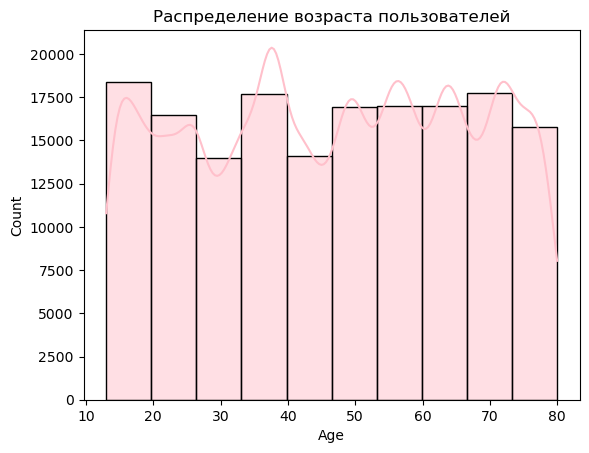

In [110]:
sns.histplot(rating_user['Age'], bins = 10, kde = True, color='pink')
plt.title('Распределение возраста пользователей')
plt.show()

C помощью метода hisplot была построена гистограмма распределения возраста пользователей.

#### 3.2 Кривая плотности рейтинга

Для наглядности создана визуализация кривой плотности рейтинга:

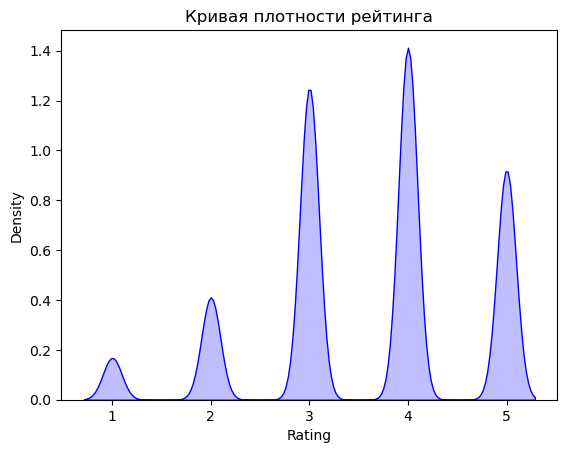

In [114]:
sns.kdeplot(rating_user['Rating'], color='blue', fill=True)
plt.title('Кривая плотности рейтинга')
plt.show()

Следовательно, можно увидеть, что пользователи больше склонны ставить фильмам оценку '4'.

#### 3.3 Распределние типов подписок по разным возрастным группам

Сгруппируем данные по возрастной группе и типу подписки:

In [127]:
subscription_counts = rating_user.groupby(['Age_Group', 'Subscription_Type'], observed=True).size().reset_index(name='Count')
print(subscription_counts)

   Age_Group Subscription_Type  Count
0      18-30             Basic   8753
1      18-30           Premium   9662
2      18-30          Standard   8254
3      30-45             Basic  14185
4      30-45           Premium  11211
5      30-45          Standard  11167
6      45-60             Basic  11977
7      45-60           Premium  12598
8      45-60          Standard  12310
9      60-90             Basic  17929
10     60-90           Premium  14991
11     60-90          Standard  16373


Была произведена группировка по двум колонкам: 'Age_Group' и 'Subscription_Type'. Метод .size() подсчитывает количество записей в каждой группе. То есть, для каждой уникальной пары значений 'Age_Group' и 'Subscription_Type' будет определено число подписчиков. Метод .reset_index() преобразует результат группировки обратно в DataFrame. Параметр name='Count' присваивает имя новому столбцу, содержащему количество подписчиков для каждой комбинации 'Age_Group' и 'Subscription_Type'.

Построение гистограммы barplot:

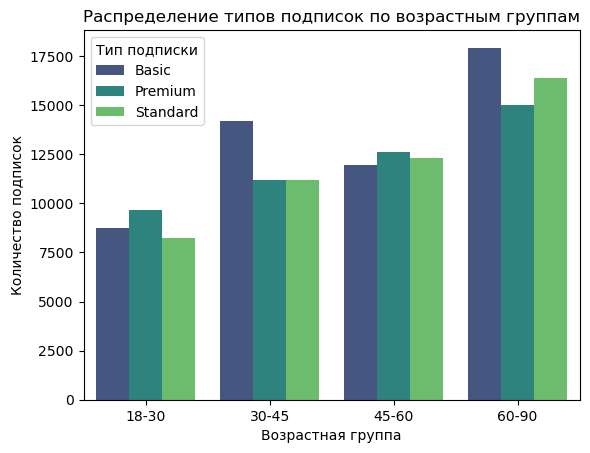

In [123]:
sns.barplot(x='Age_Group', y='Count', hue='Subscription_Type', data=subscription_counts, palette='viridis')
plt.title('Распределение типов подписок по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество подписок')
plt.legend(title='Тип подписки')
plt.show()

По оси абсцисс выводится возрастная группа, по оси ординат количество подписчиков. Из данной гистаграммы видно, что пользователи от 18 до 30 лет чаще выбирают подписку Premium, а пользователи более старшего возраста предпочитают подписку Basic.

По итогам всего вышесказанного можно понять, как с помощью языка python и его библиотек визуализировать информацию, получить необходимые данные, провести аналитику по различным критериям и категориям для различных нужд.